## Preparing the Environment

In [1]:
from __future__ import print_function
import numpy as np
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from ifqi import envs
from ifqi.evaluation import evaluation
from ifqi.algorithms.fqi.FQI import FQI

%matplotlib inline
#%matplotlib notebook

In [2]:
env = envs.LQG1D()
state_dim, action_dim, reward_dim = envs.get_space_info(env)
reward_idx = state_dim + action_dim

dataset = evaluation.collect_episodes(env, n_episodes=100)
sast = np.append(dataset[:, :reward_idx],
                 dataset[:, reward_idx + reward_dim:-1],
                 axis=1)
r = dataset[:, reward_idx]



In [3]:
states = discrete_states  = np.linspace(-10, 10, 20)
actions = discrete_actions = np.linspace(-8, 8, 20)

initial_states = np.array([[1, 2, 5, 7, 10]]).T

def make_grid(x, y):
    m = np.meshgrid(x, y, copy=False, indexing='ij')
    return np.vstack(m).reshape(2, -1).T
    

SA = make_grid(states, actions)
S, A = SA[:, 0], SA[:, 1]

## Evaluating the Optimal Q

Optimal K: [[-0.61525125]] Covariance S: 0.001


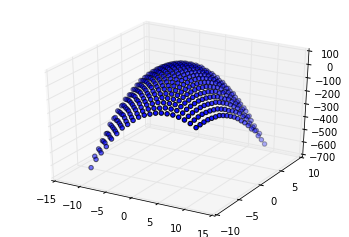

In [4]:
K, cov = env.computeOptimalK(), 0.001
print('Optimal K: {} Covariance S: {}'.format(K, cov))

Q_fun_ = np.vectorize(lambda s, a: env.computeQFunction(s, a, K, cov, 1))
Q_fun = lambda X: Q_fun_(X[:, 0], X[:, 1])

Q_opt = Q_fun(SA)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(S, A, Q_opt)

In [5]:
class QPolicy:
    def __init__(self, Q):
        self.Q = Q
    
    def draw_action(self, states, absorbing=False, evaluation=False):
        v = self.Q(make_grid(states, actions))
        return actions[v.argmax()]

class OptimalPolicy:
    K = env.computeOptimalK()[0][0]
    
    def draw_action(self, states, absorbing, evaluation=False):
        i = np.abs(actions - self.K*states).argmin()
        #print("states: {} action: {}".format(states, discrete_actions[i]))
        return discrete_actions[i]

def evaluateP(policy, i=initial_states):
    values = evaluation.evaluate_policy(env, policy, initial_states=i)
    print("values (mean {:8.2f},  se {:8.2f})\n steps (mean {:8.2f},  se {:8.2f})".format(*values))
    return values

def evaluateQ(Q, i=initial_states):
    return evaluateP(QPolicy(Q), i)

optimalP = QPolicy(Q_fun)
#optimalP = OptimalPolicy()
_ = evaluateP(optimalP)

values (mean   -65.93,  se    47.60)
 steps (mean   100.00,  se     0.00)


# Learning with FQI and `curve_fit` regressor

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

class Regressor(object):
    __slots__ = ('b', 'k')
    
    def __init__(self, b=0, k=0):
        self.b = b
        self.k = k
        
    @property
    def theta(self):
        return (self.b, self.k)
    
    @theta.setter
    def theta(self, value):
        self.b, self.k = value
    
    def fit(self, X, y):
        #print("fitting: ", end='')
        (self.b, self.k), pcov = curve_fit(self.Q, X, y, p0=[self.b, self.k])
        #print(self.b, self.k)
    
    def Q(self, sa, b, k):
        #return b - (sa[:, 1] - k *  sa[:, 0]) ** 2
        s, a = sa[:, 0], sa[:, 1]
        return - b * b * s * a - 0.5 * k * a * a - 0.4* k * s * s
    
    def predict(self, X=SA):
        return self.Q(X, self.b, self.k)
    
    def evaluate(self, X=SA):
        Q_hat = self.predict(X)
        Q_opt = Q_fun(X)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], Q_opt)
        ax.scatter(X[:, 0], X[:, 1], Q_hat, c='r', marker='^')
        
        mae = mean_absolute_error(Q_opt, Q_hat)
        mse = mean_squared_error(Q_opt, Q_hat)
        
        print("       ( mse {:8.2f}, mae {:8.2f})".format(mse, mae))
        print(" theta (   b {:8.2f},   k {:8.2f})".format(*self.theta))

        evaluateQ(self.predict)
        return Q_hat
        
    

## Evaluating regressor using Optimal data

       ( mse 35087.15, mae   141.42)
 theta (   b    -0.28,   k     0.00)
values (mean -4939.12,  se   250.00)
 steps (mean   100.00,  se     0.00)


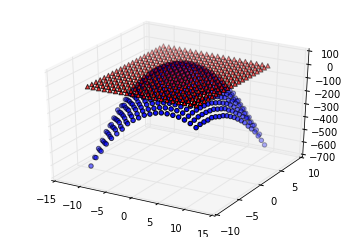

In [7]:
regressor_opt = Regressor()
regressor_opt.fit(SA, Q_opt)

Q_hat = regressor_opt.evaluate()

## Using FQI

In [8]:
regressor = Regressor()
fqi = FQI(estimator=regressor,
          state_dim=state_dim,
          action_dim=action_dim,
          discrete_actions=actions,
          gamma=env.gamma,
          horizon=env.horizon,
          verbose=False)

In [9]:
sa, y = fqi.partial_fit(sast, r)

iterations = 100
for i in range(iterations):
    sa, y = fqi.partial_fit()
    #regressor.evaluate(sa)
    #plt.show()

       ( mse 70246.59, mae   181.02)
 theta (   b     2.86,   k    12.16)
values (mean   -65.59,  se    47.67)
 steps (mean   100.00,  se     0.00)


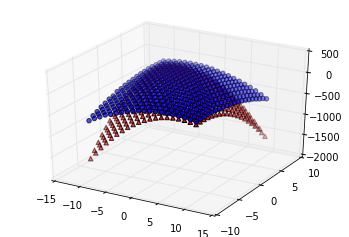

In [10]:
pred = regressor.evaluate()

## Show how Theta changes

In [11]:
import copy

regressor0 = Regressor()
fqi0 = FQI(estimator=regressor0,
          state_dim=state_dim,
          action_dim=action_dim,
          discrete_actions=actions,
          gamma=env.gamma,
          horizon=env.horizon,
          verbose=False)
fqi0.partial_fit(sast, r)

@np.vectorize
def compute_gradient(b, k):
    fqi = copy.deepcopy(fqi0)
    fqi._estimator.theta = (b, k)
    fqi.partial_fit()
    return fqi._estimator.theta

In [23]:
B_i, K_i = np.mgrid[-6:6:10j, -5:35:10j]
B_f, K_f = compute_gradient(B_i, K_i)

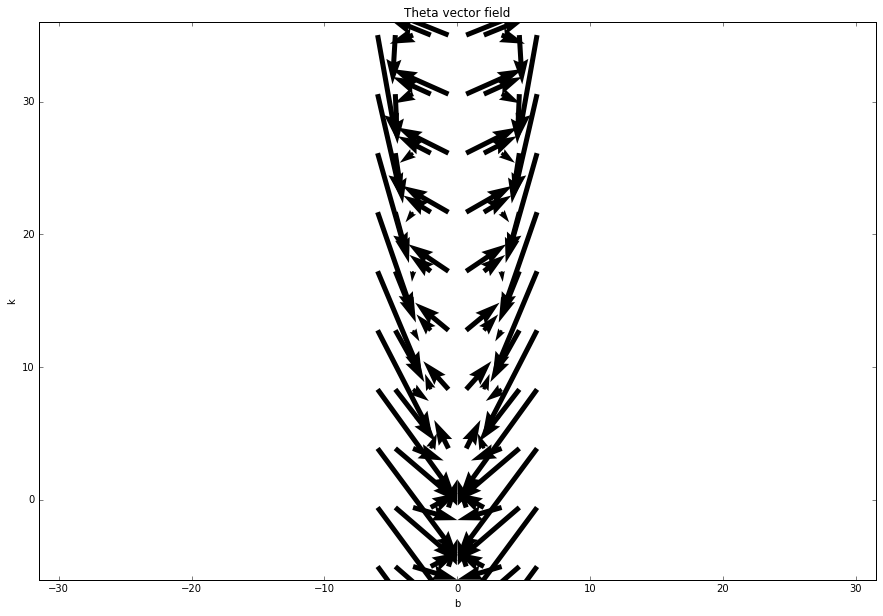

In [47]:
fig = plt.figure(figsize=(15,10))
Q = plt.quiver(B_i, K_i, B_f-B_i, K_f-K_i, units='xy', scale=1)
plt.axis('equal')
plt.axis([-6.1, 6.1, -6, 36])
plt.xlabel('b')
plt.ylabel('k')
plt.title('Theta vector field')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('grad_field.png', bbox_inches='tight')


RMSE: 2.65845098686


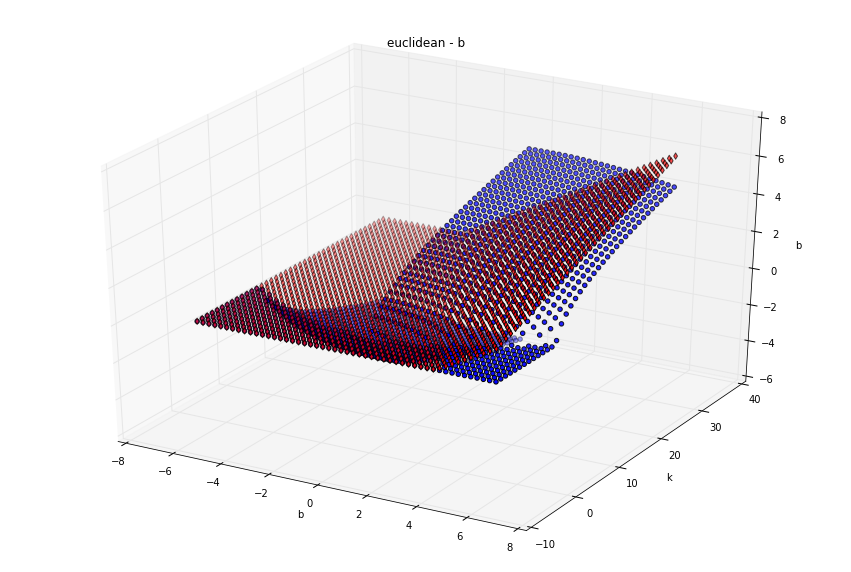

In [14]:
def soft_relu(D, a_1, a_2, a_3, a_4, b_1, b_2):
    A = np.array([[a_1,a_2],[a_3, a_4]])
    V = np.dot(D,A) + np.array([b_1, b_2])
    C = np.column_stack((V.sum(axis=1), np.zeros(V.shape[0])))
    return np.max(C, axis=1)
    #return np.log(1. + np.exp(V.sum(axis=1)))

X = np.column_stack((B_i.ravel(), K_i.ravel()))

from lmfit import  Model, Minimizer, Parameters, fit_report

gmod = Model(soft_relu)
result = gmod.fit(B_f.ravel(), D=X, a_1=1., a_2=1., a_3=1., a_4=1., b_1 = 0., b_2=0.)
# print(result.fit_report())

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, B_f)
ax.scatter(X[:,0], X[:,1], result.best_fit, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('b')
plt.title('euclidean - b')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=B_f.ravel(), y_pred=result.best_fit))))

(2000, 10)

RMSE: 1.46500863266


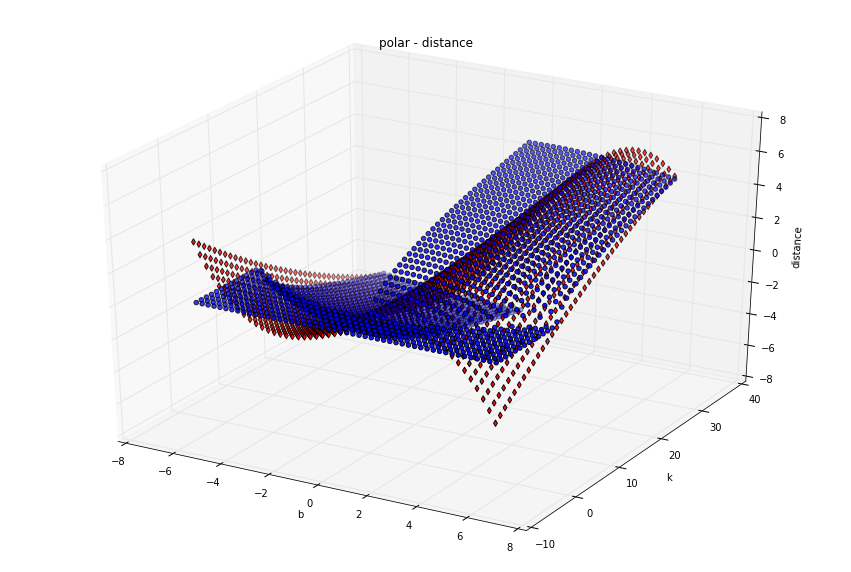

In [15]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(3), Ridge())

X = np.column_stack((B_i.ravel(), K_i.ravel()))

model.fit(X, B_f.ravel())
y_plot = model.predict(X)

print(model.steps[0][1].transform(X).shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, B_f)
ax.scatter(X[:,0], X[:,1], y_plot, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('distance')
plt.title('polar - distance')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=B_f.ravel(), y_pred=y_plot))))

(2000, 6)

RMSE: 0.104496303412


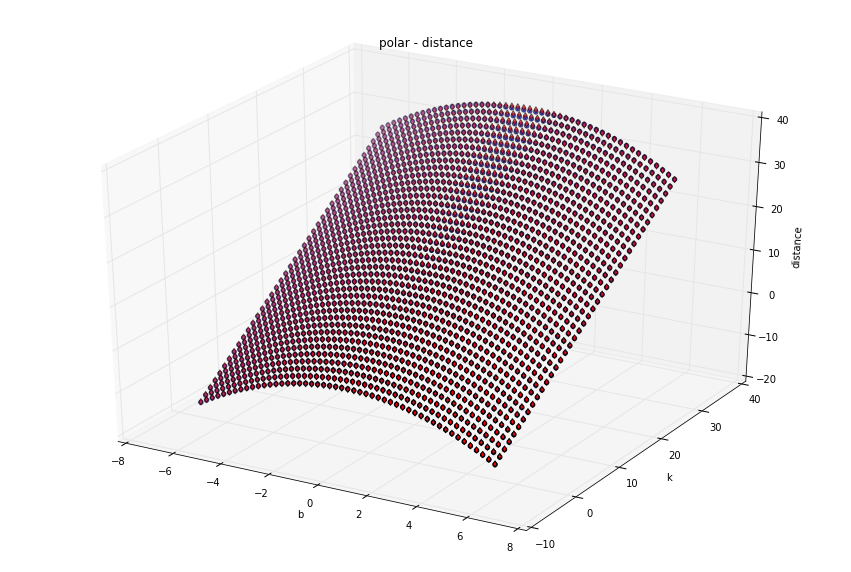

In [16]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(2), Ridge())

X = np.column_stack((B_i.ravel(), K_i.ravel()))

model.fit(X, K_f.ravel())
y_plot = model.predict(X)

print(model.steps[0][1].transform(X).shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, K_f)
ax.scatter(X[:,0], X[:,1], y_plot, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('distance')
plt.title('polar - distance')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=K_f.ravel(), y_pred=y_plot))))

# Polar coordinates

In [17]:
X = B_f - B_i
Y = K_f - K_i

polar_r = np.sqrt(X**2 + Y**2) # distance
polar_a = np.arctan2(Y, X) # angle    

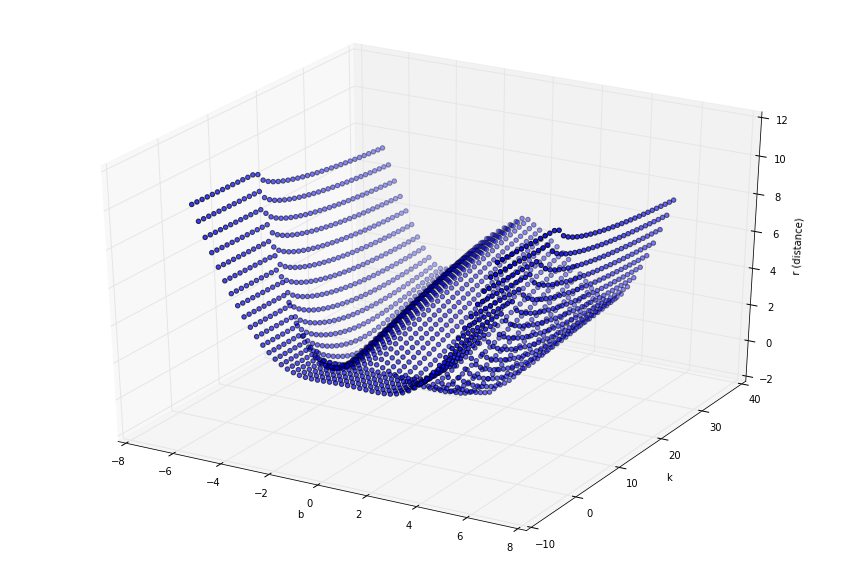

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_r)
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('r (distance)')


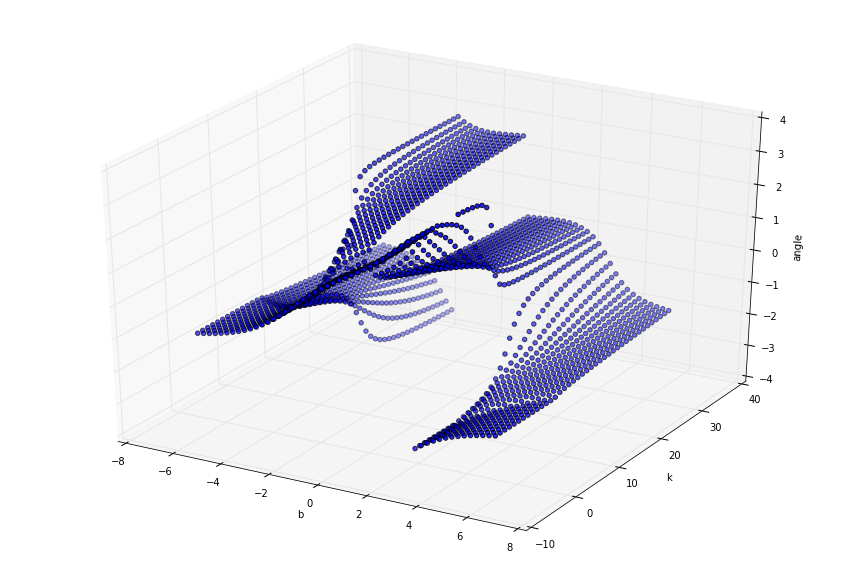

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_a)
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('angle')

In [20]:
# reconstruction
dx = polar_r * np.cos(polar_a)
dy = polar_r * np.sin(polar_a)

B_fr = B_i + dx
K_fr = K_i + dy
print(np.allclose(B_fr,B_f))
print(np.allclose(K_fr,K_f))

True
True



RMSE: 1.40699109062


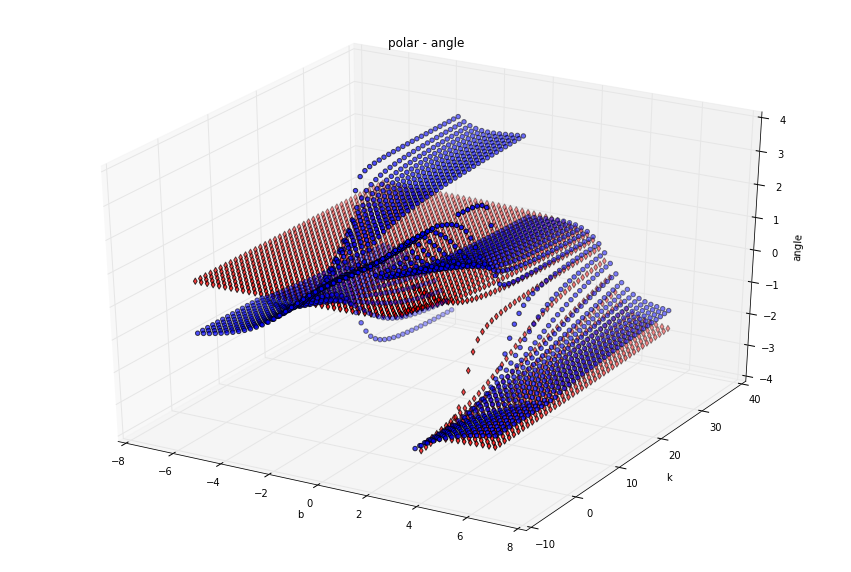

In [21]:
def atan_f(D, a_1, a_2, a_3, a_4, b_1, b_2):
    A = np.array([[a_1,a_2],[a_3, a_4]])
    V = np.dot(D,A) + np.array([b_1, b_2])
    return np.arctan2(V[:,1], V[:,0])

Y_1 = np.cos(polar_a.ravel())
Y_2 = np.sin(polar_a.ravel())
Y = np.column_stack((Y_1, Y_2))
X = np.column_stack((B_i.ravel(), K_i.ravel()))

from lmfit import  Model, Minimizer, Parameters, fit_report

gmod = Model(atan_f)
result = gmod.fit(polar_a.ravel(), D=X, a_1=1., a_2=1., a_3=1., a_4=1., b_1=0, b_2=0)
# print(result.fit_report())

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_a)
ax.scatter(X[:,0], X[:,1], result.best_fit, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('angle')
plt.title('polar - angle')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=polar_a.ravel(), y_pred=result.best_fit))))

(2000, 28)

RMSE: 0.296682215833


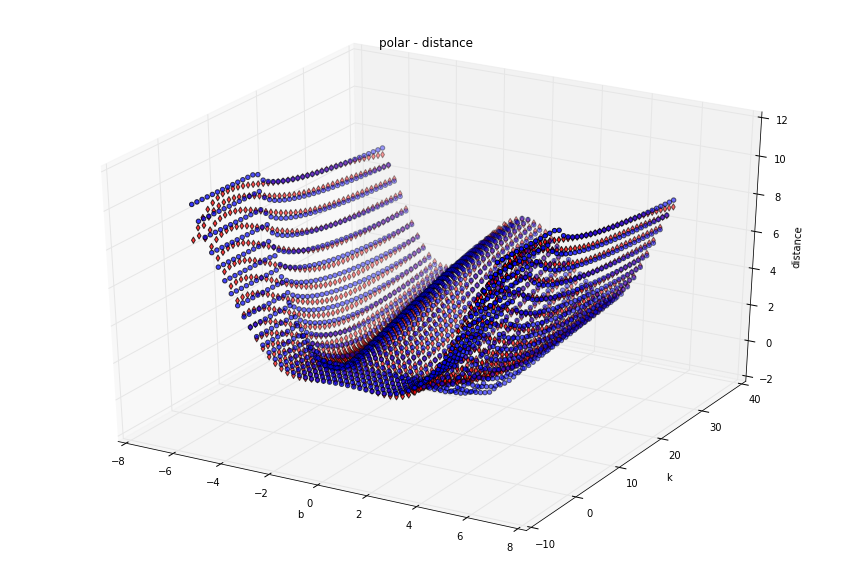

In [22]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(6), Ridge())

X = np.column_stack((B_i.ravel(), K_i.ravel()))

model.fit(X, polar_r.ravel())
y_plot = model.predict(X)

print(model.steps[0][1].transform(X).shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(B_i, K_i, polar_r)
ax.scatter(X[:,0], X[:,1], y_plot, c='r', marker='d')
ax.set_xlabel('b')
ax.set_ylabel('k')
ax.set_zlabel('distance')
plt.title('polar - distance')
print()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_true=polar_r.ravel(), y_pred=y_plot))))